In [41]:
#import necessary packages
import pandas as pd

import os
import random

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

import xgboost


from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics 
from sklearn.model_selection import train_test_split 

#to save model
import joblib

"""
usage joblib
# save the model: 
joblib.dump(model , "model.pkl")
# load the model:
model = joblib.load("model.pkl")
"""

'\nusage joblib\n# save the model: \njoblib.dump(model , "model.pkl")\n# load the model:\nmodel = joblib.load("model.pkl")\n'

In [ ]:
os.getcwd()

## We want to have a dataframe with:
* X: rows = patients, cols = proteins filled with the protein quantity
* y: rows = patients, col  = health condition (healthy, cancer A, cancer B)

In [30]:
path = "rawData/tidy.csv"
pathMet = "rawData/metadata.csv"
tidy = pd.read_csv(path, sep=",")
tidyMet = pd.read_csv(pathMet, sep=";", index_col=0)

#remove all samples which are not in the metadata index column (quality controle etc)
tidy = tidy[ (tidy["R.FileName"].isin(tidyMet.index)) ]

tidyMer    = pd.merge(tidy, tidyMet, how="left", on="R.FileName")

tidySub = tidyMer[["R.FileName", "uniprot", "meanAbu", "Cancer"]]

tidySub.Cancer.value_counts()

Breast Cancer        84630
Lung Cancer          81900
Pancreatic Cancer    81900
Colorectal Cancer    81900
Healthy              81900
Prostate Cancer      81900
Name: Cancer, dtype: int64

### To feed the data inot a model we need to reshape

In [66]:
#reshape data
#X data
tidyReshaped = tidySub.pivot(index = "R.FileName", columns = "uniprot", values = "meanAbu")
tidyReshaped.head()
#y condition
Group =  tidySub.drop(["uniprot", "meanAbu"], axis=1)
Group = Group.drop_duplicates().reset_index(drop=True)
Group.head()

#we merge to ensure that the y rows fit the corresponding x rows
data = pd.merge(tidyReshaped, Group, how="left", on="R.FileName")

#to make df purely numerical
data = data.set_index("R.FileName")

X_ = data.iloc[:, :-1]
y_ = data.iloc[:,-1]

In [32]:
data[:10]

,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7,Cancer
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,2721.810303,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,3497.142578,6626.406738,100954.500000,1.029116e+06,15354.227539,...,37423.011719,32570.783203,16396.248047,5583.424316,2844.958496,17626.980469,3184120.25,19085.271484,125766.781250,Colorectal Cancer
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,2902.563721,3281.517090,7488.952148,15695.381836,4.025498e+04,70995.250000,...,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,2919.001953,1.193392e+04,26160.638672,...,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938,Breast Cancer
J_D201211_MDIA_P705_SExp01-BGSID-105_R01,168020.156250,314351.937500,43850.906250,7771.826172,29071.429688,71324.187500,113709.164062,164368.421875,1.048406e+06,439806.000000,...,68271.148438,3907.875488,5595.822754,5423.373535,6921.024902,64960.882812,5701776.00,14410.666992,218686.546875,Healthy
J_D201211_MDIA_P705_SExp01-BGSID-106_R01,30662.833984,56251.250000,22177.605469,3568.471436,7860.810059,5676.283203,7791.059082,14281.361328,4.652126e+04,86427.093750,...,70641.117188,5911.922852,5732.438477,5113.707031,3057.126465,14672.596680,2764777.00,2809.475586,137199.046875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-107_R01,28435.175781,35869.933594,2727.172852,3502.998779,7316.994629,7915.940430,5812.071777,14288.806641,1.516024e+05,36148.906250,...,103312.960938,5317.896484,3941.360596,4759.937988,3729.927002,15953.640625,2216572.25,4058.714844,154778.015625,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-108_R01,37487.718750,106022.242188,4052.228027,3884.076416,5557.278809,15570.591797,9720.247070,38907.343750,1.918306e+05,46801.824219,...,104351.617188,6847.056641,3552.546631,2710.405029,3458.876709,22813.226562,2690729.00,3660.502686,101316.054688,Colorectal Cancer


### Now that the data is prepared we continue with the following steps:
* Create pipeline for imputing, scaling !! **Scaling is not needed for Random Forest**
* (https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf)
* Creation of training, validation and test sets
* Feature Selection, Engineering
* Model Selection

In [67]:
#Make pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

dataPrepPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ]) 

#X is already purely numerical
X = dataPrepPipe.fit_transform(X_)

In [71]:
# Encode target labels
from sklearn import preprocessing

labEnc = preprocessing.LabelEncoder() 

# apply label encoding

y = labEnc.fit_transform(y_) 

set(zip(y_, y))



{('Breast Cancer', 0),
 ('Colorectal Cancer', 1),
 ('Healthy', 2),
 ('Lung Cancer', 3),
 ('Pancreatic Cancer', 4),
 ('Prostate Cancer', 5)}

In [37]:
# Save X and y for next session

joblib.dump(y, "Models/y.pkl")
joblib.dump(X, "Models/X.pkl")


['Models/X.pkl']

In [38]:
# load saved X and y 

y = joblib.load("Models/y.pkl")
X = joblib.load("Models/X.pkl")


Original X shape: (181, 2730)
Feature selected X_new shape: (181, 977)


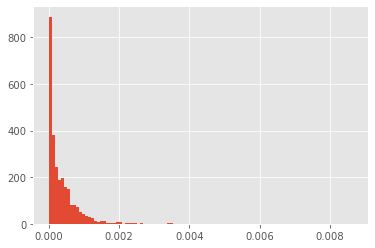

In [72]:
# Feature Selection

"""
Can be used in pipeline
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel #checkout description https://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection

#create Random Forest classifier with default hyperparameters
raFo = RandomForestClassifier(random_state=1)
raFo = raFo.fit(X, y)

#checkout importance in a histogram
plt.hist(raFo.feature_importances_, bins=100)

#get the reduced X
model = SelectFromModel(estimator = raFo, prefit=True)
X_new = model.transform(X)

print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_new.shape}")


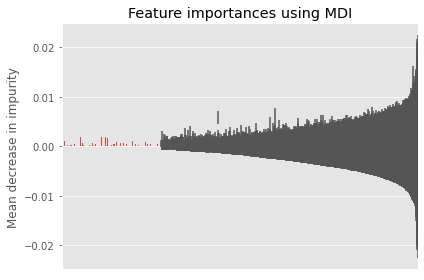

In [43]:
# Visualize feature importance

importances = raFo.feature_importances_

std = np.std([tree.feature_importances_ for tree in raFo.estimators_], axis=0)
std.sort()

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.get_xaxis().set_visible(False)
fig.tight_layout()
plt.show()


## Time to train the model


In [ ]:
# import already trained model

clf_RF = joblib.load("Models/clf_RF_X_new.pkl")
clf_XGRF = joblib.load("Models/clf_XGRF_X_new.pkl")


### Random Forest

In [55]:
#split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=4)

clf_RF = RandomForestClassifier(random_state=1)
clf_RF.fit(X_train ,y_train)
y_RFpred = clf_RF.predict(X_test)




# Model Accuracy, how often is the classifier correct?
print("Accuracy Random Forest:",metrics.accuracy_score(y_test , y_RFpred))
print(classification_report(y_test, y_RFpred))


Accuracy Random Forest: 0.7027027027027027
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.80      0.57      0.67         7
           2       0.20      1.00      0.33         1
           3       0.71      0.71      0.71         7
           4       0.86      0.75      0.80         8
           5       0.80      0.80      0.80        10

    accuracy                           0.70        37
   macro avg       0.67      0.72      0.65        37
weighted avg       0.77      0.70      0.72        37



### XGBoost Random Forest

In [63]:
#define some parameters for xgboost to avoid warnings
params = dict(tree_method="exact", 
                eval_metric='mlogloss',
                use_label_encoder =False)

clf_XGRF = xgboost.XGBClassifier(random_state=7, **params)

clf_XGRF.fit(X_train ,y_train)
y_XGRFpred = clf_XGRF.predict(X_test)

print("Accuracy XGBoost Random Forest:",metrics.accuracy_score(y_test , y_XGRFpred))
print(classification_report(y_test, y_XGRFpred))

Accuracy XGBoost Random Forest: 0.5135135135135135
              precision    recall  f1-score   support

           0       0.29      0.50      0.36         4
           1       0.43      0.43      0.43         7
           2       0.00      0.00      0.00         1
           3       0.50      0.43      0.46         7
           4       0.71      0.62      0.67         8
           5       0.75      0.60      0.67        10

    accuracy                           0.51        37
   macro avg       0.45      0.43      0.43        37
weighted avg       0.56      0.51      0.53        37



In [ ]:
#save the model
joblib.dump(clf_RF, "Models/clf_RF_X_new.pkl")
joblib.dump(clf_XGRF, "Models/clf_XGRF_X_new.pkl")

In [ ]:
# visualize confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_RFpred, labels=clf_RF.classes_) # calculate value
disp = ConfusionMatrixDisplay(confusion_matrix=cm,              # display
                              display_labels=clf_RF.classes_)
disp.plot(); 



## Compare uncertainty of Data and Model

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_RF, X_new, y, cv=5, scoring='accuracy')
Udata = scores.std()

modAcuRF = []
for rs in range(1,6):
    model = RandomForestClassifier(random_state=random.randrange(rs))
    model.fit(X_train, y_train)
    modAcuRF += [accuracy_score(y_test, model.predict(X_test))]

Umodel = np.std(modAcuRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_XGRF, X_new, y, cv=5, scoring='accuracy')
Udata = scores.std()


modAcuXGRF = []
for rs in range(1,6):
    model = xgboost.XGBClassifier(random_state=random.randrange(rs), **params)
    model.fit(X_train, y_train)
    modAcuXGRF += [accuracy_score(y_test, model.predict(X_test))]

Umodel = np.std(modAcuXGRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))